DS 5983: Large Language Models (Summer 2024)  
Dr. Roi Yehoshua  
Student name: Yuqing Qiao  
July 1, 2024  
PA3: Hugging Face Transformers

## 1. Exploratory Data Analysis:

> (a) Conduct an initial exploration of the SAMSum dataset to gain insights into the
characteristics of the dialogues and summaries.

In [ ]:
!pip install datasets evaluate rouge_score py7zr --quiet
!pip install transformers -U --quiet
!pip install accelerate -U --quiet

In [2]:
from datasets import load_dataset

dataset = load_dataset("samsum",trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


In [3]:
from pprint import pprint
pprint(dataset['train'][:2])

{'dialogue': ['Amanda: I baked  cookies. Do you want some?\r\n'
              'Jerry: Sure!\r\n'
              "Amanda: I'll bring you tomorrow :-)",
              'Olivia: Who are you voting for in this election? \r\n'
              'Oliver: Liberals as always.\r\n'
              'Olivia: Me too!!\r\n'
              'Oliver: Great'],
 'id': ['13818513', '13728867'],
 'summary': ['Amanda baked cookies and will bring Jerry some tomorrow.',
             'Olivia and Olivier are voting for liberals in this election. ']}


> (b) Plot the Length Distribution of Dialogues and Summaries in the Training Set

In [4]:
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # Remove non-alphanumeric characters
    text = "".join([char for char in text if char not in string.punctuation])
    return word_tokenize(text)

def batch_clean_text(batch):
    batch['dialogue'] = [clean_text(dialogue) for dialogue in batch['dialogue']]
    batch['summary'] = [clean_text(summary) for summary in batch['summary']]
    return batch

In [10]:
updated_ds = dataset.map(batch_clean_text,batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [30]:
import pandas as pd
# Set the format to pandas
dataset.set_format("pandas")
# Extract the train dataset and display the first few rows
df = dataset["train"][:]
df.head()


,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


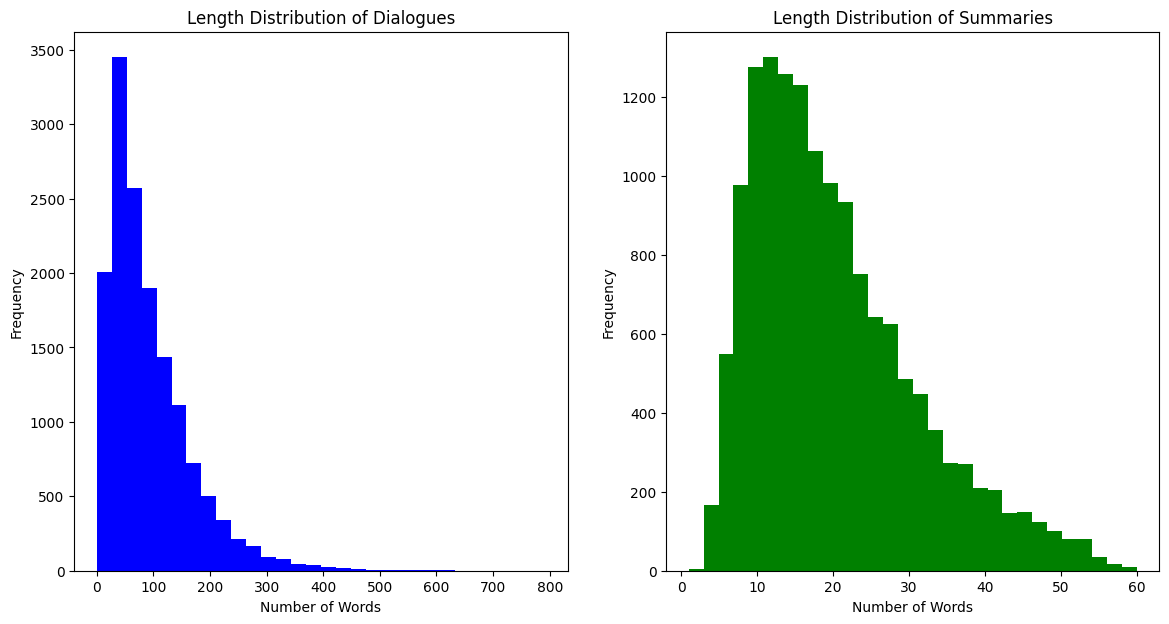

In [11]:
import matplotlib.pyplot as plt

# Extract tokenized dialogues and summaries from the training set
dialogues = [len(sample["dialogue"]) for sample in updated_ds["train"]]
summaries = [len(sample["summary"]) for sample in updated_ds["train"]]

# Plot the length distribution
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(dialogues, bins=30, color='blue')
plt.title('Length Distribution of Dialogues')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(summaries, bins=30, color='green')
plt.title('Length Distribution of Summaries')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()


> (c) Display the 20 most common words in the dialogues and their frequencies.

In [38]:
from collections import Counter

tokens = [token for dialogue in updated_ds["train"]["dialogue"] for token in dialogue]
# most common 20 words
freq = Counter(tokens)
most_common = freq.most_common(20)

for word, freq in most_common:
    print(f'{word}: {freq}')


del updated_ds
del df

i: 44151
you: 39082
the: 31569
to: 29204
a: 22279
it: 20404
and: 17728
for: 11987
in: 11563
is: 11339
that: 10885
have: 10781
of: 10770
so: 10481
me: 10240
but: 10197
im: 9497
be: 9174
what: 8676
we: 8652


## 3. Inference with Pre-trained Models:

> (a) Choose at least three pre-trained summarization models from the Hugging Face
model hub, such as facebook/bart-large-cnn or t5-large.

In [12]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the models and tokenizers
models = {
    "BART": {
        "model": AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn"),
        "tokenizer": AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
    },
    "T5": {
        "model": AutoModelForSeq2SeqLM.from_pretrained("t5-large"),
        "tokenizer": AutoTokenizer.from_pretrained("t5-large")
    },
    "PEGASUS": {
        "model": AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum"),
        "tokenizer": AutoTokenizer.from_pretrained("google/pegasus-xsum")
    }
}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


> (b) Use the models to generate summaries for a few randomly selected dialogues. Analyze the quality of these summaries: Are they coherent? Do they capture the essential points in the conversation?

In [21]:
import torch
from transformers import pipeline
import evaluate

# Set the number of samples
n_samples = 3
# Select random dialogues
sample_dialogues = dataset['test'].shuffle(seed=42).select(range(n_samples))

# Create summarizer pipelines for each model
device = 0 if torch.cuda.is_available() else -1
summarizers = {model_name: pipeline("summarization", model=models[model_name]['model'], tokenizer=models[model_name]['tokenizer'], device=device) for model_name in models}

# Function to generate summary
def generate_summary(dialogue, model_name):
    summarizer = summarizers[model_name]
    output = summarizer(dialogue)
    generated_summary = output[0]['summary_text']
    return generated_summary

# Generate summaries
summaries = {model_name: [] for model_name in models}

for dialogue in sample_dialogues:
    for model_name in models:
        summaries[model_name].append(generate_summary(dialogue['dialogue'], model_name))

# Display the summaries
for i, dialogue in enumerate(sample_dialogues):
    print(f"Dialogue {i+1}:\n{dialogue['dialogue']}\n")
    for model_name in models:
        print(f"{model_name} Summary:\n{summaries[model_name][i]}\n")
    print("="*50)



Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 64, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 142, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your

Dialogue 1:
Claire: <file_photo>
Kim: Looks delicious...
Linda: No way... Look what I'm cooking right now:
Linda: <file_photo>
Claire: hahahaha 
Kim: Curry dream team
Claire: Enjoy your dinner :*

BART Summary:
Linda: No way... Look what I'm cooking right now. Claire: hahahaha   Kim: Curry dream team. Linda: What's for dinner? Claire: Curry. Kim: Looks delicious... Linda: Curry! Claire: Enjoy your dinner :*

T5 Summary:
Linda: 'look what i'm cooking right now: no way... ... look what I'm preparing right now'

PEGASUS Summary:
Claire:

Dialogue 2:
Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job.
Derek: This is not normal. I saw it last week…
Alyssa: What do you think about it?
Derek: I can fart bright stripes and bright stars better then she sings.
Alyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way.
Derek: It is 😂

BART Summary:
Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job. Derek: I 

In [25]:
# Evaluate with ROUGE scores
rouge = evaluate.load("rouge")

for model_name in models:
    rouge_metric = evaluate.load("rouge")
    for i, dialogue in enumerate(sample_dialogues):
        generated_summary = summaries[model_name][i]
        reference_summary = dialogue['summary']
        rouge_metric.add_batch(predictions=[generated_summary], references=[reference_summary])
    rouge_score = rouge_metric.compute()
    print(f"{model_name} ROUGE Scores:")
    pprint(rouge_score)
    print("="*50)

BART ROUGE Scores:
{'rouge1': 0.2939873801723092,
 'rouge2': 0.05911221395092362,
 'rougeL': 0.20667622254580756,
 'rougeLsum': 0.20667622254580756}
T5 ROUGE Scores:
{'rouge1': 0.15527065527065528,
 'rouge2': 0.01550387596899225,
 'rougeL': 0.12564102564102564,
 'rougeLsum': 0.12564102564102564}
PEGASUS ROUGE Scores:
{'rouge1': 0.1379697927643133,
 'rouge2': 0.0,
 'rougeL': 0.13796979276431331,
 'rougeLsum': 0.13796979276431331}


### Conclution
3 dialogues is tested. All models perform poorly on the second dialogues, which could be due to an issue with the dataset's intention. Although the ROUGE scores show that BART produces better summarizations, I think T5 produces better results. Therefore, human evaluation is still needed.

> BART:  
Strengths: BART captures key phrases from the dialogues effectively.
Weaknesses: It struggles to understand the overall content, leading to summaries that are often disjointed and lack coherence. It generally does not perform well on dialogues.  

> T5:  
Strengths: T5 produces coherent and structured summaries, effectively capturing the essential points of the dialogues.  
Weaknesses: While generally concise, T5 may sometimes omit minor details.  

> PEGASUS:  
Strengths: PEGASUS leverages pre-trained knowledge, which can sometimes enhance the informativeness of the summaries.
Weaknesses: It often introduces extraneous information not present in the original dialogues, resulting in summaries that lack coherence and relevance to the specific conversation.


## 4. Fine-Tuning:  
> (a) Choose one of the pre-trained summarization models from the previous part.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset


In [34]:
# torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/bart-large-cnn"
dataset = load_dataset("samsum",trust_remote_code=True)

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import psutil
# Process.memory_info is expressed in bytes, so convert to megabytes
print(f'RAM used: {psutil. Process().memory_info().rss / (1024**2):.2f} MB')

RAM used: 2037.37 MB


> (b) Preprocess the dataset to fit it to the input format required by the chosen model,
which may include tokenizing the dialogues and their summaries.

In [3]:
# Tokenization function
def preprocess_function(examples):
    inputs = examples['dialogue']
    targets = examples['summary']
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")

    # Tokenize the summaries
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the preprocessing to the dataset with batch processing
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary"])

# Print a sample to verify
print(tokenized_datasets['train'][0])


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

{'id': '13818513', 'input_ids': [0, 10127, 5219, 35, 38, 17241, 1437, 15269, 4, 1832, 47, 236, 103, 116, 50121, 50118, 39237, 35, 9136, 328, 50121, 50118, 10127, 5219, 35, 38, 581, 836, 47, 3859, 48433, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


> (c) Train the model on the SAMSum corpus, monitoring its performance on the vali-
dation set, and adjust the hyperparameters as needed.

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate

finetuned_model_name = f'{model_name}-finetuned-samsum'
batch_size = 16

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=finetuned_model_name,
    num_train_epochs=2,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    fp16=True,
    predict_with_generate=True,
    # logging_dir='./logs',
    # logging_steps=10,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


> (d)Employ appropriate metrics for evaluating summarization quality, such as ROUGE
scores, which compare the generated summaries against the reference summaries.

In [5]:
# Load the ROUGE metric
rouge = evaluate.load("rouge")

# Define a compute metrics function using ROUGE
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return result

# Create a Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


### Metrics Before training BART

In [39]:
torch.cuda.empty_cache()

In [15]:
# before training evaluation
preds_output= trainer.predict(tokenized_datasets["test"])
preds_output.metrics

{'test_loss': 10.231649398803711,
 'test_rouge1': 0.3065360867349508,
 'test_rouge2': 0.10186119578990031,
 'test_rougeL': 0.23021281721512687,
 'test_rougeLsum': 0.2303120985093354,
 'test_runtime': 268.5939,
 'test_samples_per_second': 3.049,
 'test_steps_per_second': 0.097}

In [6]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.577000,0.322953,0.379466,0.190061,0.276850,0.276752
2,0.227900,0.316085,0.409582,0.208038,0.314859,0.314785


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=1842, training_loss=0.3407160399661649, metrics={'train_runtime': 1218.961, 'train_samples_per_second': 24.171, 'train_steps_per_second': 1.511, 'total_flos': 1.5962892499156992e+16, 'train_loss': 0.3407160399661649, 'epoch': 2.0})

In [7]:
# Evaluate the model
results = trainer.evaluate()
pprint(results)


{'eval_loss': 0.31608545780181885, 'eval_rouge1': 0.4095815871365392, 'eval_rouge2': 0.20803774621551024, 'eval_rougeL': 0.3148589232706943, 'eval_rougeLsum': 0.31478526984278493, 'eval_runtime': 180.8413, 'eval_samples_per_second': 4.523, 'eval_steps_per_second': 0.288, 'epoch': 2.0}


In [9]:
# save model
model.save_pretrained(finetuned_model_name)
tokenizer.save_pretrained(finetuned_model_name)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('facebook/bart-large-cnn-finetuned-samsum/tokenizer_config.json',
 'facebook/bart-large-cnn-finetuned-samsum/special_tokens_map.json',
 'facebook/bart-large-cnn-finetuned-samsum/vocab.json',
 'facebook/bart-large-cnn-finetuned-samsum/merges.txt',
 'facebook/bart-large-cnn-finetuned-samsum/added_tokens.json',
 'facebook/bart-large-cnn-finetuned-samsum/tokenizer.json')

## Evaluation and Analysis: BART fine-tuned
> (a) Evaluate the fine-tuned model’s performance on the test set. Compare these results
to the model’s pre-fine-tuning performance using the same dialogues to assess the
impact of fine-tuning.


In [12]:
import torch
from transformers import pipeline
import evaluate

# Set the number of samples
n_samples = 3
# Select random dialogues
sample_dialogues = dataset['test'].shuffle(seed=42).select(range(n_samples))

# Create summarizer pipelines for each model
device = "cuda" if torch.cuda.is_available() else "cpu"
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=device)

# Function to generate summary
def generate_summary(dialogue):
    output = summarizer(dialogue)
    generated_summary = output[0]['summary_text']
    return generated_summary

# Generate summaries
summaries = []

for dialogue in sample_dialogues:
    summaries.append(generate_summary(dialogue['dialogue']))

# Display the summaries
for i, dialogue in enumerate(sample_dialogues):
    print(f"Dialogue {i+1}:\n{dialogue['dialogue']}\n")
    print(f"Summary:\n{summaries[i]}\n")
    print("="*50)

Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 142, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 142, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Dialogue 1:
Claire: <file_photo>
Kim: Looks delicious...
Linda: No way... Look what I'm cooking right now:
Linda: <file_photo>
Claire: hahahaha 
Kim: Curry dream team
Claire: Enjoy your dinner :*

Summary:
Linda is cooking curry for dinner right now. Claire, Kim and Linda think it looks delicious, but Linda thinks it's a waste of time as she's already made it.   She sends Claire a photo of the food that she's cooking. Claire and Kim are impressed.

Dialogue 2:
Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job.
Derek: This is not normal. I saw it last week…
Alyssa: What do you think about it?
Derek: I can fart bright stripes and bright stars better then she sings.
Alyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way.
Derek: It is 😂

Summary:
Derek and Alyssa like Fergie’s national anthem. Derek farts better than she sings it.  He thinks it's funny in a good way.   He likes the fact that she acts like she nailed it, to

### Before fine tunning result:

```code
Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 64, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 142, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 200, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 142, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Dialogue 1:
Claire: <file_photo>
Kim: Looks delicious...
Linda: No way... Look what I'm cooking right now:
Linda: <file_photo>
Claire: hahahaha
Kim: Curry dream team
Claire: Enjoy your dinner :*

BART Summary:
Linda: No way... Look what I'm cooking right now. Claire: hahahaha   Kim: Curry dream team. Linda: What's for dinner? Claire: Curry. Kim: Looks delicious... Linda: Curry! Claire: Enjoy your dinner :*

T5 Summary:
Linda: 'look what i'm cooking right now: no way... ... look what I'm preparing right now'

PEGASUS Summary:
Claire:

==================================================
Dialogue 2:
Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job.
Derek: This is not normal. I saw it last week…
Alyssa: What do you think about it?
Derek: I can fart bright stripes and bright stars better then she sings.
Alyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way.
Derek: It is 😂

BART Summary:
Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job. Derek: I can fart bright stripes and bright stars better then she sings. But at least it's funny in a good way, Alyssa says. The best part is that she acts like she nailed it, Derek adds.

T5 Summary:
Derek: i can fart bright stripes and bright stars better then she sings . but at least it's funny in a good way .

PEGASUS Summary:
In case you missed it, here are some highlights from the Super Bowl:

==================================================
Dialogue 3:
Ann: Hi, is the laptop still available?
Josh: Yes it is
Ann: I can pay 200 dollars
Josh: The price is 250 and it's non-negotiable
Ann: Do you have a bag for it? Some other accessories?
Josh: I have a bag and a small usb mouse
Ann: Sounds good, I'll take it, where can I pick it up?

BART Summary:
Ann: Hi, is the laptop still available? Josh: Yes it is. Ann: I can pay 200 dollars for it. Josh: The price is 250 and it's non-negotiable.Ann: Sounds good, I'll take it, where can I pick it up?

T5 Summary:
the price is 250 dollars and it's non-negotiable . do you have a bag and a small usb mouse?

PEGASUS Summary:
Ann: Hi, is the laptop still available Josh: Hi, is the laptop still available Ann: Hi, is the laptop still available Ann: Hi, is the laptop still available Ann: Hi, is the laptop still available Ann: Hi, is the laptop still available Ann: Hi, is the laptop still

==================================================
```

> (b) Analyze the generated summaries for improvements in capturing key points, co-
herence, and fluency. Discuss the fine-tuning’s impact on the model’s ability to
summarize dialogues.

Before Fine-Tuning (BART)

BART Summary: Captures multiple dialogue exchanges but fails to generate a cohesive summary. Some phrases are redundant and lack proper structuring.

After Fine-Tuning (BART)

BART Summary: The fine-tuned BART model generates a cohesive summary that captures key points about Linda cooking curry, and the positive reactions from Claire and Kim. It correctly interprets the exchange and provides a complete narrative.

